In [1]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('lines', linewidth=5)
rc('text', usetex=True)

import cmasher as cmr

In [2]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [3]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [4]:
def plot_bar_data(data_df,x_col="x",series_readable_id_col="name", arb_text_list=None, figsize=(8, 5), series_readable_id_map=None, x_label=None, y_label=None, special_color_map=None, num_colors=None, title="Figure Title", grid=True, save_path=None, show=True):

    # make a simple bar chart of the data labellinig each by it's series_readable_id_col
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    
    #plot using plt.bar
    # but lets make subplots for heirarchical groups
    # first level, on left we want bars where name contains 50_200 and right is where name has 100_600
    # in each of those groups, we want to split into set where contains cp_attack and where doesn't
    # them finally we sort each final group by x_col
    # mak sure we position them separately on the x axis with some space between them

    fig, ax = plt.subplots(figsize=figsize)

    # group level 1
    left_group = data_df[data_df[series_readable_id_col].str.contains("50_200")]
    right_group = data_df[data_df[series_readable_id_col].str.contains("100_600")]

    # group level 2

    left_left_group = left_group[left_group[series_readable_id_col].str.contains("cp_attack")]
    left_right_group = left_group[~left_group[series_readable_id_col].str.contains("cp_attack")]

    right_left_group = right_group[right_group[series_readable_id_col].str.contains("cp_attack")]
    right_right_group = right_group[~right_group[series_readable_id_col].str.contains("cp_attack")] 

    # sort data_df by the x_col, i.e. the bar heights

    left_left_group = left_left_group.sort_values(by=[x_col], ascending=False)
    left_right_group = left_right_group.sort_values(by=[x_col], ascending=False)
    right_left_group = right_left_group.sort_values(by=[x_col], ascending=False)
    right_right_group = right_right_group.sort_values(by=[x_col], ascending=False)

    all_groups = [left_left_group, left_right_group, right_left_group, right_right_group]

    # hardcode 27 bar positions leaving out the 3 required for the gaps
    # 6 bars per group, 4 groups, 3 gaps
    # width is 7 bars - the 1 gap bar
    width = 7 

    widths = [8,4,8,4]

    offset = 0

    overall_position_list = []
    for width in widths:
        overall_position_list += list(range(offset, offset+width))
        offset += width + 1


    global_idx = 0
    all_labels = []
    for i, grp in enumerate(all_groups):
        if isinstance(series_readable_id_map, dict):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(series_readable_id_map)
        elif isinstance(series_readable_id_map, Callable):
            grp[series_readable_id_col] = grp[series_readable_id_col].map(lambda x: series_readable_id_map(x))

        for j, x_val in enumerate(grp[x_col]):
            label = grp[series_readable_id_col].iloc[j]
            all_labels.append(label)
            color = cmap[j]
            ax.bar(overall_position_list[global_idx], x_val, color=color, alpha=0.8)
            global_idx += 1

    # Set the x ticks to be the names located at the center of the correct bar
    ax.set_xticks(overall_position_list, all_labels)

    # draw dotted vertical lines at the gap positions
    ax.axvline(x=overall_position_list[8]-1, color="black", linestyle="--", linewidth=0.7)
    ax.axvline(x=overall_position_list[12]-1, color="black", linestyle="--", linewidth=0.7)
    ax.axvline(x=overall_position_list[20]-1, color="black", linestyle="--", linewidth=0.7)
    

    # turn on grid  
    ax.set_axisbelow(True)
    ax.grid(grid,zorder=0,axis="y")
    # increase horiz grid density 
    ax.xaxis.grid(which="minor", linestyle="-", linewidth=0.5, color="black", zorder=0)
    ax.set_yticks(np.arange(0, 1.1, 0.05))

    # plot text below the x axis ticks
    if arb_text_list is not None:
        for text_tup in arb_text_list:
            ax.text(*text_tup, transform=ax.transAxes)

    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_label)
    plt.ylabel(y_label if y_label else x_col)

    # set y lim to be 0 to 1
    ax.set_ylim(0.5,1.0)

    # angle labels
    plt.xticks(rotation=45, ha="right")

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [5]:
def name_extractor(x):
    x = x.replace("dipper_high_eval", " Dipper")
    x = x.replace("gpt_p4_eval", " GPT")
    x = x.replace("core", "")
    x = x.replace("gen", "")
    x = x.replace("simple_1", "LeftHash ")
    x = x.replace("algorithm-3", "SelfHash ")

    x = x.replace("_eval", "")
    
    x = x.replace("_", " ")

    x = x.replace("cp attack ", " CP-")

    x = x.replace("%","\\%")

    if "50 200" in x:
        x = x.replace("50 200", "")
        # x = "T=200, " + x
    elif "100 600" in x:
        x = x.replace("100 600", "")
        # x = "T=600, " + x
    elif "200 1000" in x:
        x = x.replace("200 1000", "")
        x = "T=1000, " + x
    return x


In [6]:
fig_name = "core_attacked_AUC_bars"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,Name,_wandb,attacked_z_score_roc_auc
0,core_algorithm-3_100_600_dipper_high_eval,NaN,0.990193
1,core_simple_1_100_600_dipper_high_eval,NaN,0.987282
2,core_simple_1_100_600_gen_cp_attack_1-25%_eval,NaN,0.985382
3,core_simple_1_100_600_gen_cp_attack_3-25%_eval,NaN,0.984610
4,core_algorithm-3_100_600_gen_cp_attack_3-25%_eval,NaN,0.972066
5,core_algorithm-3_100_600_gen_cp_attack_1-25%_eval,NaN,0.967350
6,core_algorithm-3_50_200_dipper_high_eval,NaN,0.965516
7,core_simple_1_50_200_dipper_high_eval,NaN,0.925570
8,core_algorithm-3_100_600_gpt_p4_eval,NaN,0.924650
9,core_simple_1_100_600_gpt_p4_eval,NaN,0.922727


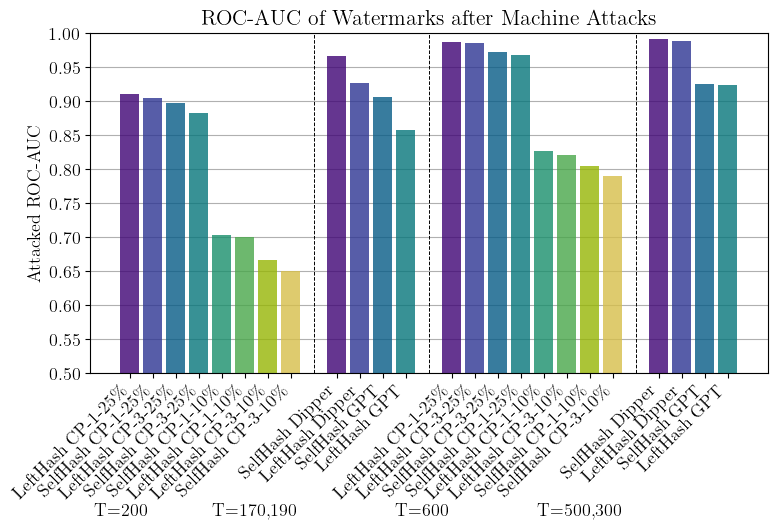

In [7]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

plot_bar_data(
    df,
    x_col="attacked_z_score_roc_auc",
    # x_label="Watermarking Settings",
    y_label="Attacked ROC-AUC",
    series_readable_id_col="Name",
    num_colors = 8,
    arb_text_list=[(0.007, -0.42, "T=200"),(0.18, -0.42, "T=170,190"), (0.45, -0.42, "T=600"),(0.66, -0.42, "T=500,300")],
    figsize=(8,6),
    series_readable_id_map=name_extractor,
    title="ROC-AUC of Watermarks after Machine Attacks",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
    show=True
)
    

In [8]:

def plot_grouped_series_data(data_df, x_col="idx_T", y_col="avg", y_err_df=None, y_err_col=None, y_err_join_idx=None, x_name=None,y_name=None, x_lim=None, y_lim=None, limit_x_series=None, limit_x_series_map=None, solid_alpha=0.95, dash_style=":", dash_color="gray", dash_alpha=0.4, series_id_col="id", series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, title="Figure Title", legend_loc="upper left", grid=True, save_path=None, show=True):

    # get unique series ids
    series_ids = data_df[series_id_col].unique()
    series_readable_ids = data_df[series_readable_id_col].unique()

    # check that can make a 1-1 mapping, i.e. the human readble names are unique and map to 1 series id
    assert len(series_readable_ids) == len(series_ids), "series_readable_ids is not a 1-1 mapping"
    print(series_readable_ids)

    # make human-readable series ids mapping
    series_readable_ids = data_df[[series_id_col, series_readable_id_col]].drop_duplicates().set_index(series_id_col).to_dict()[series_readable_id_col]

    if isinstance(series_readable_id_map, dict):
        series_readable_ids = {k:series_readable_id_map[v] for k,v in series_readable_ids.items()}
        print("Used dict tom map series_readable_ids")
    elif isinstance(series_readable_id_map, Callable):
        print(series_readable_ids.items())
        series_readable_ids = {k:series_readable_id_map(v) for k,v in series_readable_ids.items()}
        print("Used callable to map series_readable_ids")
    print(series_readable_ids)


    # set up figure
    fig, ax = plt.subplots(figsize=(10, 6))


    ####################################
    # # Custom sorting and droping stuff
    # # sort by average y_col value in the series
    sorted_series_ids = data_df.groupby(series_id_col)[y_col].mean().sort_values(ascending=False).index

    # trucate the series themselves if necessary
    if limit_x_series is not None: 
        # only keep up to limit_x_series points
        data_df = data_df[data_df[x_col] <= limit_x_series]

    
    # get a randomly dispersed colormap from cmr for these series
    # So that we can tell them apart
    cmap = cmr.take_cmap_colors("cmr.rainforest", len(sorted_series_ids), cmap_range=(0.2, 0.8), return_fmt="hex")

    ####################################
    legend_skip_mask = []
    # plot each series
    for i, series_id in enumerate(sorted_series_ids):
        if special_color_map and series_readable_ids[series_id] in special_color_map.keys():
            color = special_color_map[series_readable_ids[series_id]]
        else:
            color = cmap[i]

        series_df = data_df[data_df[series_id_col] == series_id]
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id], color=COLORS[series_id], alpha=solid_alpha)
        # ax.plot(series_df[x_col], series_df[y_col], label=series_readable_ids[series_id])

        # limit this specfic series if necessary using the limit map
        if limit_x_series_map is not None and series_readable_ids[series_id] in limit_x_series_map.keys():
            # only keep up to the limit in the map for this name
            series_df = series_df[series_df[x_col] <= limit_x_series_map[series_readable_ids[series_id]]]

        # add std error bars if the col exists
        # ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=solid_alpha)
        if y_err_df is not None:
            #  plot the stderr col in the df matching it to the x_col in the series_df
            # get the error series that corresponds to the idx col values in the series_df
            y_err_subdf = y_err_df[y_err_df[series_id_col] == series_id]
            err_series = y_err_subdf[y_err_col]
            # err_series = y_err_subdf[y_err_subdf[y_err_join_idx].isin(y_err_subdf[y_err_join_idx])][y_err_col]
            ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=color, alpha=0.1)
            
        ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=solid_alpha)
        legend_skip_mask.append(False)

        # if the series was limited, plot the rest as a dashed line in gray
        if limit_x_series_map is not None and series_readable_ids[series_id] in limit_x_series_map.keys():

            series_df = data_df[data_df[series_id_col] == series_id]
            # only keep after the limit in the map for this name
            series_df = series_df[series_df[x_col] >= limit_x_series_map[series_readable_ids[series_id]]]

            # do the same err plotting but with dashed lines
            if y_err_df is not None:
                #  plot the stderr col in the df matching it to the x_col in the series_df
                # get the error series that corresponds to the idx col values in the series_df
                y_err_subdf = y_err_df[y_err_df[series_id_col] == series_id]
                err_series = y_err_subdf[y_err_col]
                # err_series = y_err_subdf[y_err_subdf[y_err_join_idx].isin(y_err_subdf[y_err_join_idx])][y_err_col]
                # ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=dash_color, alpha=0.1, linestyle=dash_style)
                ax.errorbar(series_df[x_col], series_df[y_col], yerr=err_series, label=series_readable_ids[series_id], color=color, alpha=0.1)

            ax.plot(series_df[x_col], series_df[y_col],  label=series_readable_ids[series_id], color=color, alpha=dash_alpha)
            legend_skip_mask.append(True)
                

        # # print the final seriesvlaue for each
        # print(f"{series_readable_ids[series_id]} final : {series_df[y_col].iloc[-1]}")

    # set up legend, but exclude stderr if it's there
    handles, labels = ax.get_legend_handles_labels()
    print(handles)
    print(labels)
    if y_err_df is not None:
        # assume they're the first half
        handles = handles[:len(handles)//2]
        labels = labels[:len(labels)//2]

    # if series were limited and dashing occured, we need to remove the duplicates where a dashed was also added
    # we can do this by removing every element with a dash as the linestyle, zipped with labels
    if limit_x_series_map:
        # handles, labels = zip(*[(h,l) for h,l in zip(handles, labels) if h.get_linestyle() != dash_style])
        # print([h.get_linestyle() for h in handles])
        # filter based on the legend_skip_mask
        handles, labels = zip(*[(h,l) for h,l,skip in zip(handles, labels, legend_skip_mask) if not skip])

    ax.legend(handles, labels,loc=legend_loc, fontsize=12)
    
    # set up title
    ax.set_title(title)
    # label axes
    ax.set_xlabel(x_name if x_name else x_col)
    ax.set_ylabel(y_name if y_name else y_col)

    #set upper y_lim to 1
    ax.set_ylim(y_lim if y_lim else None)
    ax.set_xlim(x_lim if x_lim else None)

    # turn on grid
    ax.grid(grid)

    # tight
    fig.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")
    
    # show figure
    if show:
        plt.show()


In [9]:
def name_extractor(x):
    x = x.replace("dipper_high_eval", "Dipper")
    x = x.replace("gpt_p4_eval", "GPT")
    x = x.replace("core", "")
    x = x.replace("gen", "")
    x = x.replace("eval", "")
    x = x.replace("simple_1", "LeftHash")
    x = x.replace("algorithm-3", "SelfHash")

    x = x.replace("_eval", "")

    x = x.replace("50_200", "")
    x = x.replace("100_600", "")
    
    x = x.replace("_", " ")
        
    x = x.replace("cp attack ", " CP-")

    x = x.replace("%","\\%")


    return x.strip()

In [10]:
fig_name = "core_clean_TPR_at_T_200"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,name,tpr_at
0,13,jk4jivka,0,core_algorithm-3_50_200_gen_eval,0.000000
1,13,jk4jivka,1,core_algorithm-3_50_200_gen_eval,0.000000
2,13,jk4jivka,2,core_algorithm-3_50_200_gen_eval,0.000000
3,13,jk4jivka,3,core_algorithm-3_50_200_gen_eval,0.000000
4,13,jk4jivka,4,core_algorithm-3_50_200_gen_eval,0.025995
...,...,...,...,...,...
393,14,v7rn2qwo,195,core_simple_1_50_200_gen_eval,0.981335
394,14,v7rn2qwo,196,core_simple_1_50_200_gen_eval,0.982759
395,14,v7rn2qwo,197,core_simple_1_50_200_gen_eval,0.981818
396,14,v7rn2qwo,198,core_simple_1_50_200_gen_eval,1.000000


['core_algorithm-3_50_200_gen_eval' 'core_simple_1_50_200_gen_eval']
dict_items([('jk4jivka', 'core_algorithm-3_50_200_gen_eval'), ('v7rn2qwo', 'core_simple_1_50_200_gen_eval')])
Used callable to map series_readable_ids
{'jk4jivka': 'SelfHash', 'v7rn2qwo': 'LeftHash'}
[<matplotlib.lines.Line2D object at 0x7f9847d5da50>, <matplotlib.lines.Line2D object at 0x7f9847d5d810>]
['SelfHash', 'LeftHash']


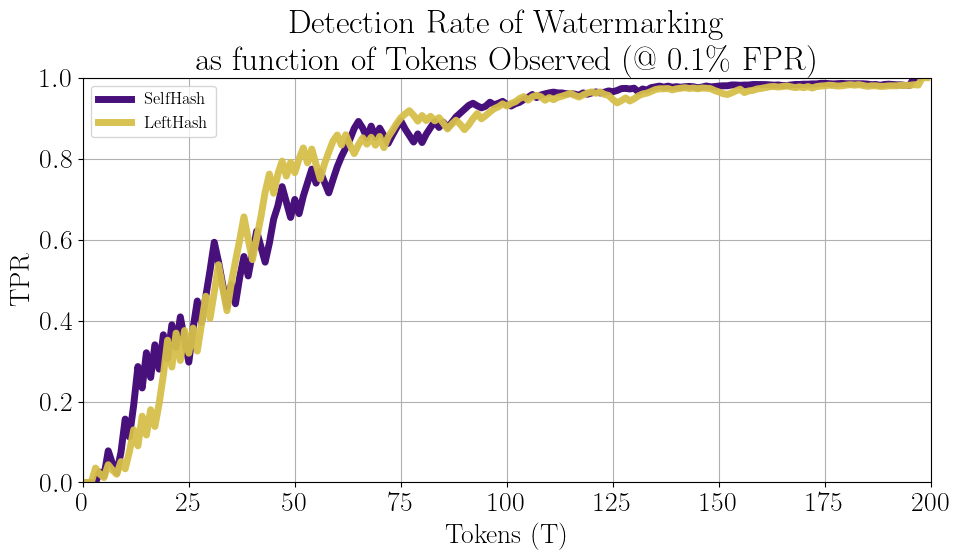

In [11]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})

plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="tpr_at",
    x_name="Tokens (T)",
    y_name="TPR",
    x_lim=(0,200),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking\nas function of Tokens Observed (@ 0.1\% FPR)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [12]:
fig_name = "core_attacked_TPR_at_T_200"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,name,tpr_at
0,0,zj35kp99,0,core_algorithm-3_50_200_dipper_high_eval,0.000000
1,0,zj35kp99,1,core_algorithm-3_50_200_dipper_high_eval,0.000000
2,0,zj35kp99,2,core_algorithm-3_50_200_dipper_high_eval,0.000000
3,0,zj35kp99,3,core_algorithm-3_50_200_dipper_high_eval,0.000000
4,0,zj35kp99,4,core_algorithm-3_50_200_dipper_high_eval,0.007899
...,...,...,...,...,...
2383,15,t2x3945h,193,core_algorithm-3_50_200_gen_cp_attack_3-10%_eval,0.000000
2384,15,t2x3945h,194,core_algorithm-3_50_200_gen_cp_attack_3-10%_eval,0.000000
2385,15,t2x3945h,195,core_algorithm-3_50_200_gen_cp_attack_3-10%_eval,0.000000
2386,15,t2x3945h,196,core_algorithm-3_50_200_gen_cp_attack_3-10%_eval,0.052632


['core_algorithm-3_50_200_dipper_high_eval'
 'core_simple_1_50_200_dipper_high_eval'
 'core_simple_1_50_200_gen_cp_attack_1-25%_eval'
 'core_algorithm-3_50_200_gpt_p4_eval'
 'core_algorithm-3_50_200_gen_cp_attack_1-25%_eval'
 'core_simple_1_50_200_gen_cp_attack_3-25%_eval'
 'core_algorithm-3_50_200_gen_cp_attack_3-25%_eval'
 'core_simple_1_50_200_gpt_p4_eval'
 'core_algorithm-3_50_200_gen_cp_attack_1-10%_eval'
 'core_simple_1_50_200_gen_cp_attack_1-10%_eval'
 'core_simple_1_50_200_gen_cp_attack_3-10%_eval'
 'core_algorithm-3_50_200_gen_cp_attack_3-10%_eval']
dict_items([('zj35kp99', 'core_algorithm-3_50_200_dipper_high_eval'), ('yow2ywpi', 'core_simple_1_50_200_dipper_high_eval'), ('momt7pue', 'core_simple_1_50_200_gen_cp_attack_1-25%_eval'), ('p6zpm1ev', 'core_algorithm-3_50_200_gpt_p4_eval'), ('x8w6lb1t', 'core_algorithm-3_50_200_gen_cp_attack_1-25%_eval'), ('68097wck', 'core_simple_1_50_200_gen_cp_attack_3-25%_eval'), ('u7qgizi6', 'core_algorithm-3_50_200_gen_cp_attack_3-25%_eval'),

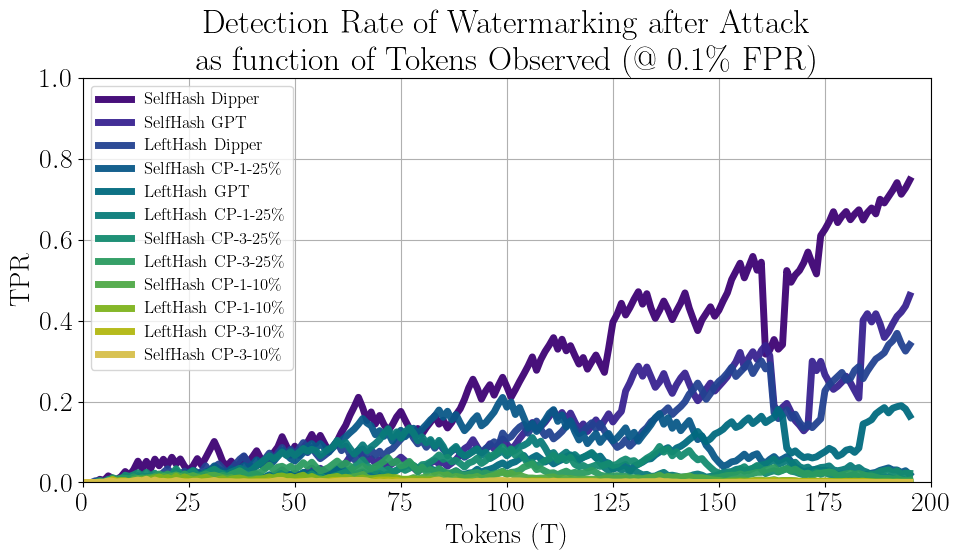

In [13]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="tpr_at",
    x_name="Tokens (T)",
    y_name="TPR",
    x_lim=(0,200),
    y_lim=(0,1),
    limit_x_series=195,
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking after Attack\nas function of Tokens Observed (@ 0.1\% FPR)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [14]:
fig_name = "core_clean_TPR_at_T_600"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,name,tpr_at
0,12,1854n7sn,0,core_simple_1_100_600_gen_eval,0.000000
1,12,1854n7sn,1,core_simple_1_100_600_gen_eval,0.000000
2,12,1854n7sn,2,core_simple_1_100_600_gen_eval,0.000000
3,12,1854n7sn,3,core_simple_1_100_600_gen_eval,0.036591
4,12,1854n7sn,4,core_simple_1_100_600_gen_eval,0.019372
...,...,...,...,...,...
1193,11,ytdcxelt,593,core_algorithm-3_100_600_gen_eval,0.993789
1194,11,ytdcxelt,594,core_algorithm-3_100_600_gen_eval,0.993773
1195,11,ytdcxelt,595,core_algorithm-3_100_600_gen_eval,0.993663
1196,11,ytdcxelt,596,core_algorithm-3_100_600_gen_eval,1.000000


['core_simple_1_100_600_gen_eval' 'core_algorithm-3_100_600_gen_eval']
dict_items([('1854n7sn', 'core_simple_1_100_600_gen_eval'), ('ytdcxelt', 'core_algorithm-3_100_600_gen_eval')])
Used callable to map series_readable_ids
{'1854n7sn': 'LeftHash', 'ytdcxelt': 'SelfHash'}
[<matplotlib.lines.Line2D object at 0x7f98462c3a90>, <matplotlib.lines.Line2D object at 0x7f98462c3be0>]
['LeftHash', 'SelfHash']


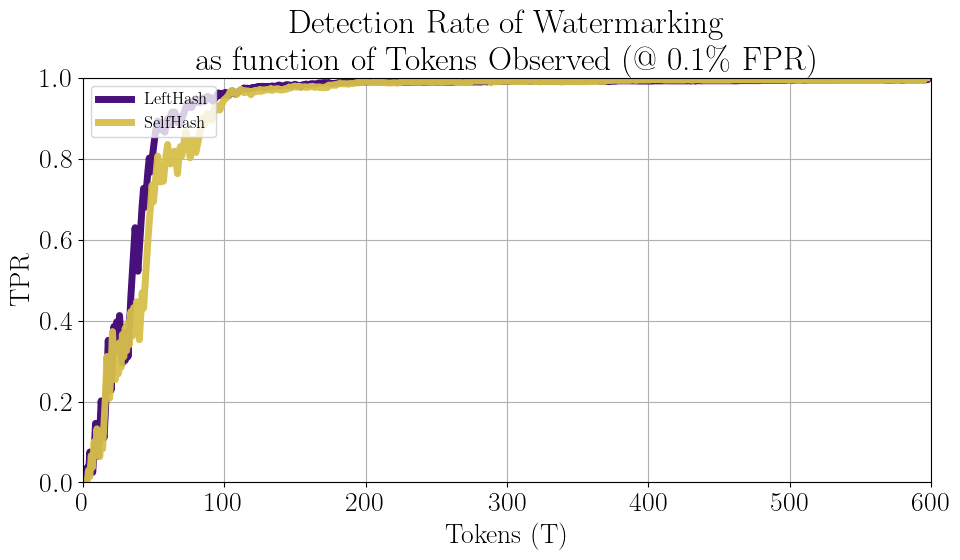

In [15]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="tpr_at",
    x_name="Tokens (T)",
    y_name="TPR",
    x_lim=(0,600),
    y_lim=(0,1),
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking\nas function of Tokens Observed (@ 0.1\% FPR)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [16]:
fig_name = "core_attacked_TPR_at_T_600"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,id,idx_T,name,tpr_at
0,2,8g4dlm73,0,core_algorithm-3_100_600_dipper_high_eval,0.000000
1,2,8g4dlm73,1,core_algorithm-3_100_600_dipper_high_eval,0.000000
2,2,8g4dlm73,2,core_algorithm-3_100_600_dipper_high_eval,0.000000
3,2,8g4dlm73,3,core_algorithm-3_100_600_dipper_high_eval,0.000000
4,2,8g4dlm73,4,core_algorithm-3_100_600_dipper_high_eval,0.006766
...,...,...,...,...,...
7183,0,xwkvsx4i,593,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval,0.014028
7184,0,xwkvsx4i,594,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval,0.014199
7185,0,xwkvsx4i,595,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval,0.011416
7186,0,xwkvsx4i,596,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval,0.196721


['core_algorithm-3_100_600_dipper_high_eval'
 'core_simple_1_100_600_dipper_high_eval'
 'core_simple_1_100_600_gen_cp_attack_1-25%_eval'
 'core_simple_1_100_600_gen_cp_attack_3-25%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_3-25%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_1-25%_eval'
 'core_algorithm-3_100_600_gpt_p4_eval'
 'core_simple_1_100_600_gpt_p4_eval'
 'core_simple_1_100_600_gen_cp_attack_1-10%_eval'
 'core_simple_1_100_600_gen_cp_attack_3-10%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_1-10%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_3-10%_eval']
dict_items([('8g4dlm73', 'core_algorithm-3_100_600_dipper_high_eval'), ('qnufjt3o', 'core_simple_1_100_600_dipper_high_eval'), ('yidwfqh1', 'core_simple_1_100_600_gen_cp_attack_1-25%_eval'), ('hwgl9y2i', 'core_simple_1_100_600_gen_cp_attack_3-25%_eval'), ('jcodgemc', 'core_algorithm-3_100_600_gen_cp_attack_3-25%_eval'), ('ve3ueyzu', 'core_algorithm-3_100_600_gen_cp_attack_1-25%_eval'), ('hw21adf2', 'core_algorithm-3_100

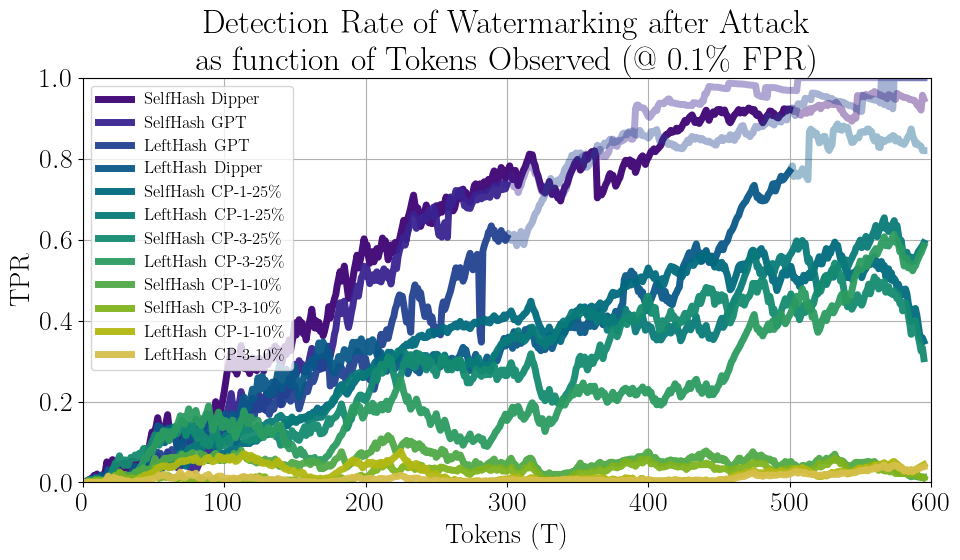

In [17]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="tpr_at",
    x_name="Tokens (T)",
    y_name="TPR",
    x_lim=(0,600),
    y_lim=(0,1),
    limit_x_series=595,
    limit_x_series_map={"SelfHash  GPT": 300, "LeftHash  GPT": 300, "SelfHash  Dipper": 500, "LeftHash  Dipper": 500},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    special_color_map={"Human Avg":"black"},
    title="Detection Rate of Watermarking after Attack\nas function of Tokens Observed (@ 0.1\% FPR)",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [18]:
fig_name = "core_clean_AUC_at_T_600"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,12,0.660468,1854n7sn,0,core_simple_1_100_600_gen_eval
1,12,0.720827,1854n7sn,1,core_simple_1_100_600_gen_eval
2,12,0.765923,1854n7sn,2,core_simple_1_100_600_gen_eval
3,12,0.789110,1854n7sn,3,core_simple_1_100_600_gen_eval
4,12,0.813565,1854n7sn,4,core_simple_1_100_600_gen_eval
...,...,...,...,...,...
1193,11,0.999789,ytdcxelt,593,core_algorithm-3_100_600_gen_eval
1194,11,0.999797,ytdcxelt,594,core_algorithm-3_100_600_gen_eval
1195,11,0.999790,ytdcxelt,595,core_algorithm-3_100_600_gen_eval
1196,11,1.000000,ytdcxelt,596,core_algorithm-3_100_600_gen_eval


['core_simple_1_100_600_gen_eval' 'core_algorithm-3_100_600_gen_eval']
dict_items([('1854n7sn', 'core_simple_1_100_600_gen_eval'), ('ytdcxelt', 'core_algorithm-3_100_600_gen_eval')])
Used callable to map series_readable_ids
{'1854n7sn': 'LeftHash', 'ytdcxelt': 'SelfHash'}
[<matplotlib.lines.Line2D object at 0x7f9845df79d0>, <matplotlib.lines.Line2D object at 0x7f9845df7b20>]
['LeftHash', 'SelfHash']


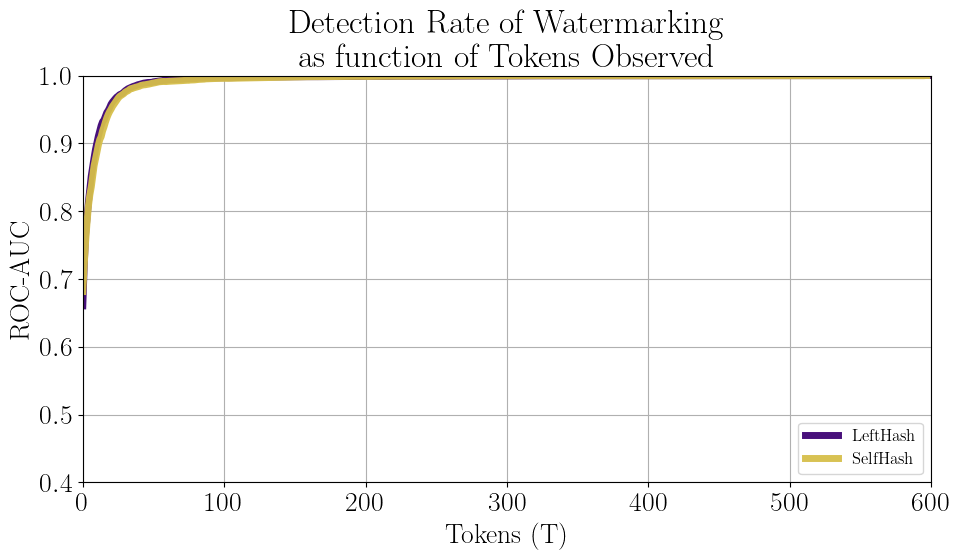

In [19]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(0,600),
    y_lim=(0.4,1),
    legend_loc="lower right",
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [20]:
fig_name = "core_attacked_AUC_at_T_600"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)
df

,_defaultColorIndex,aucs,id,idx_T,name
0,2,0.593371,8g4dlm73,0,core_algorithm-3_100_600_dipper_high_eval
1,2,0.617985,8g4dlm73,1,core_algorithm-3_100_600_dipper_high_eval
2,2,0.643614,8g4dlm73,2,core_algorithm-3_100_600_dipper_high_eval
3,2,0.658309,8g4dlm73,3,core_algorithm-3_100_600_dipper_high_eval
4,2,0.673905,8g4dlm73,4,core_algorithm-3_100_600_dipper_high_eval
...,...,...,...,...,...
7183,0,0.802884,xwkvsx4i,593,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval
7184,0,0.800351,xwkvsx4i,594,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval
7185,0,0.800121,xwkvsx4i,595,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval
7186,0,0.882827,xwkvsx4i,596,core_algorithm-3_100_600_gen_cp_attack_3-10%_eval


['core_algorithm-3_100_600_dipper_high_eval'
 'core_simple_1_100_600_dipper_high_eval'
 'core_simple_1_100_600_gen_cp_attack_1-25%_eval'
 'core_simple_1_100_600_gen_cp_attack_3-25%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_3-25%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_1-25%_eval'
 'core_algorithm-3_100_600_gpt_p4_eval'
 'core_simple_1_100_600_gpt_p4_eval'
 'core_simple_1_100_600_gen_cp_attack_1-10%_eval'
 'core_simple_1_100_600_gen_cp_attack_3-10%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_1-10%_eval'
 'core_algorithm-3_100_600_gen_cp_attack_3-10%_eval']
dict_items([('8g4dlm73', 'core_algorithm-3_100_600_dipper_high_eval'), ('qnufjt3o', 'core_simple_1_100_600_dipper_high_eval'), ('yidwfqh1', 'core_simple_1_100_600_gen_cp_attack_1-25%_eval'), ('hwgl9y2i', 'core_simple_1_100_600_gen_cp_attack_3-25%_eval'), ('jcodgemc', 'core_algorithm-3_100_600_gen_cp_attack_3-25%_eval'), ('ve3ueyzu', 'core_algorithm-3_100_600_gen_cp_attack_1-25%_eval'), ('hw21adf2', 'core_algorithm-3_100

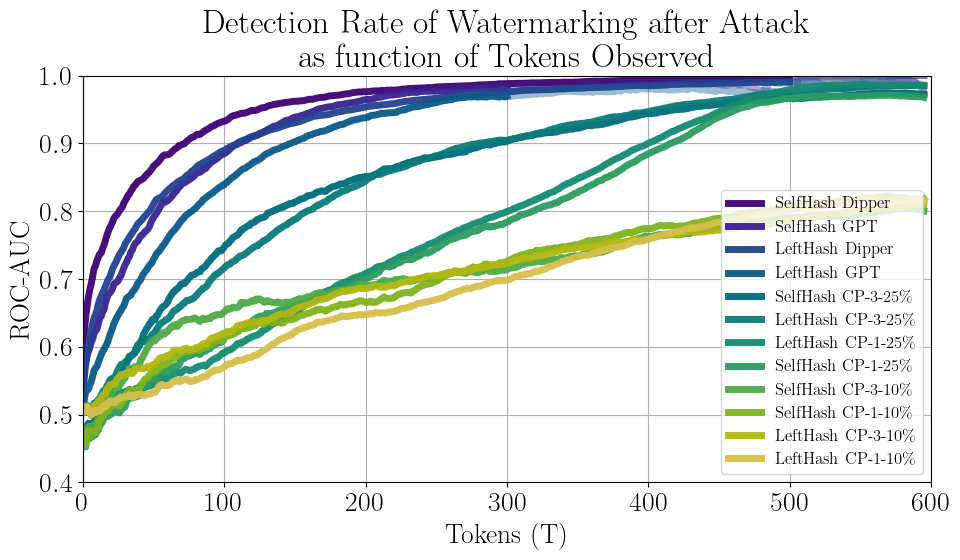

In [21]:
plot_grouped_series_data(
    data_df=df,
    x_col="idx_T",
    y_col="aucs",
    x_name="Tokens (T)",
    y_name="ROC-AUC",
    x_lim=(0,600),
    y_lim=(0.4,1),
    legend_loc="lower right",
    limit_x_series=595,
    limit_x_series_map={"SelfHash  GPT": 300, "LeftHash  GPT": 300, "SelfHash  Dipper": 500, "LeftHash  Dipper": 500},
    series_id_col="id",
    series_readable_id_col="name",
    series_readable_id_map=name_extractor,
    title="Detection Rate of Watermarking after Attack\nas function of Tokens Observed",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)